# 1. Les imports 

In [18]:
import numpy as np 
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)

In [17]:
df_train = pd.read_csv('./WAICF_train.csv')
df_test = pd.read_csv('./WAICF_test.csv')

Columns (2,3,4,7) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (3,4,5,7) have mixed types.Specify dtype option on import or set low_memory=False.


# 2. Nettoyage necessaire 

In [19]:
# drop Nan
df_train = df_train.dropna()

# Encodage corse en int 
df_train['department'][df_train.loc[:,'department'] == '2B'] = 720 
df_train['department'][df_train.loc[:,'department'] == '2A'] = 620 
df_train.department = df_train.department.astype(int)

df_train['speed_limitation'] = df_train['speed_limitation'].replace('800', '80').replace('500', '50')

# France et DOM - TOM ?
df_train.loc[df_train['country'] == 'A', 'country'] = 1
df_train.loc[df_train['country'] == 'B', 'country'] = 2
df_train.country = df_train.country.astype(int)

# Longitude et latitude 
df_train["longitude"] = [float(str(i).replace(",", ".")) for i in df_train["longitude"]]
df_train["latitude"] = [float(str(i).replace(",", ".")) for i in df_train["latitude"]]

# On supprime adresse number
df_train.drop('address_nbr', axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 3. Separation du jeu de donnée 

In [20]:
X = df_train.drop(['accident_id','accident_type', 'latitude', 'longitude'], axis=1)
y = df_train['accident_type']

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. On partage le poid de notre jeu de donnée entre les accidents grave et non grave via la fonction sklearn : compute_class_weight

In [22]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# 5. On instancie notre modele  

In [23]:
model = CatBoostClassifier(
    task_type= 'GPU',
    eval_metric = 'BalancedAccuracy', 
    learning_rate = 0.075, 
    iterations = 1500,
    loss_function = 'Logloss',
    depth=5,
    # random_seed=9,
    l2_leaf_reg=14,
    # bagging_temperature=8,
    random_strength=42,
    class_weights = class_weights,
    grow_policy='Depthwise', 
)

In [24]:
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100)

Metric BalancedAccuracy is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6177631	test: 0.6153221	best: 0.6153221 (0)	total: 31.8ms	remaining: 47.6s
1:	learn: 0.6173194	test: 0.6150444	best: 0.6153221 (0)	total: 57.5ms	remaining: 43.1s
2:	learn: 0.6186648	test: 0.6160630	best: 0.6160630 (2)	total: 83.1ms	remaining: 41.5s
3:	learn: 0.6282414	test: 0.6253121	best: 0.6253121 (3)	total: 108ms	remaining: 40.6s
4:	learn: 0.6283454	test: 0.6254593	best: 0.6254593 (4)	total: 134ms	remaining: 40s
5:	learn: 0.6327327	test: 0.6298812	best: 0.6298812 (5)	total: 160ms	remaining: 39.9s
6:	learn: 0.6327121	test: 0.6300666	best: 0.6300666 (6)	total: 186ms	remaining: 39.7s
7:	learn: 0.6369906	test: 0.6344758	best: 0.6344758 (7)	total: 213ms	remaining: 39.7s
8:	learn: 0.6396684	test: 0.6374041	best: 0.6374041 (8)	total: 239ms	remaining: 39.7s
9:	learn: 0.6419239	test: 0.6396273	best: 0.6396273 (9)	total: 266ms	remaining: 39.6s
10:	learn: 0.6412510	test: 0.6393348	best: 0.6396273 (9)	total: 292ms	remaining: 39.5s
11:	learn: 0.6427396	test: 0.6402541	best: 0.6402541

# 6. On effectue la prediction sur le jeu de test :

In [25]:
model.score(X_train, y_train)

0.692974502825394

In [26]:
pred = model.predict(X_valid)
print('Balanced accuracy: {:.2f}'.format(balanced_accuracy_score(y_valid, pred)))

Balanced accuracy: 0.69


# 7. On visualise l'importance de nos features 

Text(0.5, 1.0, 'Feature Importance')

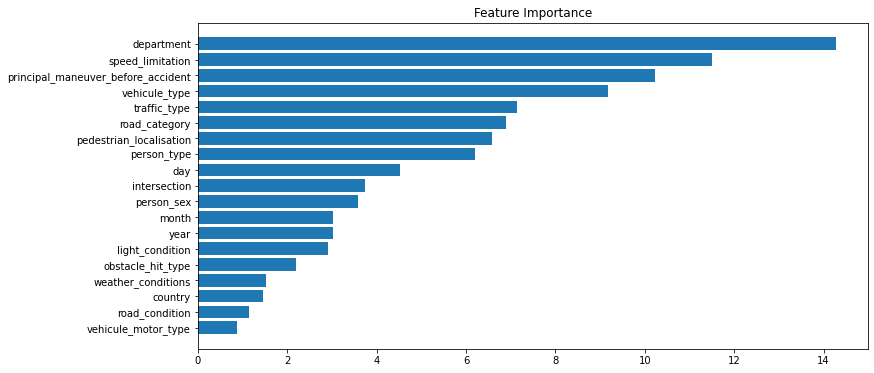

In [27]:
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_valid.columns)[sorted_idx])
plt.title('Feature Importance')

# 8. Enfin on effectue la prediction à soumettre via le set de test de la plateforme trustii

In [28]:
df_test = pd.read_csv('./WAICF_test.csv')
df_test = df_test.drop(['accident_id', 'trustii_id', 'address_nbr'], axis=1)
df_test

Columns (3,4,5,7) have mixed types.Specify dtype option on import or set low_memory=False.


,year,longitude,latitude,department,road_category,traffic_type,speed_limitation,intersection,pedestrian_localisation,light_condition,weather_conditions,road_condition,obstacle_hit_type,person_type,person_sex,vehicule_type,principal_maneuver_before_accident,vehicule_motor_type,day,month,country
0,2020.0,"2,4384100","48,7053500",91,4.0,2.0,50.0,3.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,7.0,15.0,1.0,7.0,3.0,A
1,2020.0,"2,4384100","48,7053500",91,4.0,2.0,50.0,3.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,33.0,2.0,1.0,7.0,3.0,A
2,2020.0,"2,4384100","48,7053500",91,4.0,2.0,50.0,3.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,7.0,15.0,1.0,7.0,3.0,A
3,2020.0,"2,4384100","48,7053500",91,4.0,2.0,50.0,3.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,33.0,2.0,1.0,7.0,3.0,A
4,2020.0,"2,4100000","48,6900000",91,4.0,2.0,50.0,9.0,-1.0,2.0,7.0,1.0,0.0,1.0,1.0,7.0,26.0,1.0,7.0,3.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410479,2020.0,-2.92632,56.473539,99,4.0,6.0,30.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,8.0,12.0,B
410480,2020.0,-4.267565,55.802353,99,6.0,9.0,30.0,3.0,0.0,1.0,1.0,1.0,0.0,3.0,2.0,NaN,NaN,NaN,13.0,11.0,B
410481,2020.0,-2.271903,57.186317,99,4.0,6.0,60.0,8.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,15.0,4.0,B
410482,2020.0,-3.968753,55.95094,99,6.0,6.0,30.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,15.0,12.0,B


In [29]:
# Encodage corse en int 
df_test['department'][df_test.loc[:,'department'] == '2B'] = 720 
df_test['department'][df_test.loc[:,'department'] == '2A'] = 620 
df_test.department = df_test.department.astype(int)

# France et DOM - TOM ?
df_test.loc[df_test['country'] == 'A', 'country'] = 1
df_test.loc[df_test['country'] == 'B', 'country'] = 2
df_test.country = df_test.country.astype(int)

# Longitude et latitude 
df_test["longitude"] = [float(str(i).replace(",", ".")) for i in df_test["longitude"]]
df_test["latitude"] = [float(str(i).replace(",", ".")) for i in df_test["latitude"]]

df_test['speed_limitation'] = df_test['speed_limitation'].replace('800', '80').replace('500', '50')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
pred = model.predict(df_test)
pred

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [31]:
df_sub = pd.read_csv('./WAICF_test.csv')
df_sub = df_sub.set_index('trustii_id')
df_sub['accident_type'] = pred

df_sub.to_csv('my_submission2.csv', index=True, encoding='UTF-8')

Columns (3,4,5,7) have mixed types.Specify dtype option on import or set low_memory=False.
